This notebook is based on https://www.kaggle.com/its7171/2class-object-detection-inference <br>
I added a small filtering step to reduce the number of False Positives

In [1]:
import pandas as pd
d = pd.read_csv('/home/thinh/nfl/test_player_tracking.csv')
IS_PRIVATE = d.shape != (19269, 12)
print(IS_PRIVATE)

IS_PRIVATE = True

False


In [2]:
# if IS_PRIVATE:
#     !pip install ../input/nfl-lib/timm-0.1.26-py3-none-any.whl
#     !tar xfz ../input/nfl-lib/pkgs.tgz
#     # for pytorch1.6
#     cmd = "sed -i -e 's/ \/ / \/\/ /' timm-efficientdet-pytorch/effdet/bench.py"
#     !$cmd
    
#     !pip install ../input/timm-pytorch-image-models/timm-0.3.2-py3-none-any.whl > /dev/null
#     !pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null
    

SyntaxError: unexpected EOF while parsing (<ipython-input-2-bdc102e54056>, line 10)

In [3]:
import sys
sys.path.insert(0, "efficientdet-pytorch-master")
sys.path.insert(0, "omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pandas as pd
import gc
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet
import warnings
from IPython.core.debugger import set_trace

warnings.filterwarnings("ignore")

DATA_ROOT_PATH = '/home/thinh/nfl/test_images'
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

In [4]:
#################
# SET CONSTANTS
#################

IMG_SIZE = 768
DETECTION_THRESHOLD = 0.4
DETECTOR_FILTERING_THRESHOLD = 0.3

In [5]:
def mk_images(video_name, video_labels, video_dir, out_dir, only_with_impact=True):
    video_path=f"{video_dir}/{video_name}"
    video_name = os.path.basename(video_path)
    vidcap = cv2.VideoCapture(video_path)
    if only_with_impact:
        boxes_all = video_labels.query("video == @video_name")
        print(video_path, boxes_all[boxes_all.impact == 1.0].shape[0])
    else:
        print(video_path)
    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        frame += 1
        if only_with_impact:
            boxes = video_labels.query("video == @video_name and frame == @frame")
            boxes_with_impact = boxes[boxes.impact == 1.0]
            if boxes_with_impact.shape[0] == 0:
                continue
        img_name = f"{video_name}_frame{frame}"
        image_path = f'{out_dir}/{video_name}'.replace('.mp4',f'_{frame}.png')
        _ = cv2.imwrite(image_path, img)

In [6]:
if IS_PRIVATE:
    out_dir = DATA_ROOT_PATH
    if not os.path.exists(out_dir):
        !mkdir -p $out_dir
        video_dir = '/home/thinh/nfl/test'
        uniq_video = [path.split('/')[-1] for path in glob(f'{video_dir}/*.mp4')]
        for video_name in uniq_video:
            mk_images(video_name, pd.DataFrame(), video_dir, out_dir, only_with_impact=False)

/home/thinh/nfl/test/58102_002798_Sideline.mp4
/home/thinh/nfl/test/57995_000109_Endzone.mp4
/home/thinh/nfl/test/57906_000718_Endzone.mp4
/home/thinh/nfl/test/57906_000718_Sideline.mp4
/home/thinh/nfl/test/57995_000109_Sideline.mp4
/home/thinh/nfl/test/58102_002798_Endzone.mp4


In [7]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=768, width=768, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [8]:
class DatasetRetriever(Dataset):
    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [13]:
def load_net(checkpoint_path):
#     config = get_efficientdet_config('tf_efficientdet_d5')
#     net = EfficientDet(config, pretrained_backbone=False)
#     config.num_classes = 2
#     config.image_size=IMG_SIZE
#     net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
#     checkpoint = torch.load(checkpoint_path, map_location="cuda:0")
#     net.load_state_dict(checkpoint['model_state_dict'])
#     net = DetBenchEval(net, config)
#     net.eval();
#     return net.cuda()



    config = get_efficientdet_config('tf_efficientdet_d5')

    # config.num_classes = 2
    config.image_size = [768, 768]
    config.norm_kwargs=dict(eps=.001, momentum=.01)

    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load(checkpoint_path, map_location="cuda:0")
    
    net.reset_head(num_classes=2)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    net = DetBenchPredict(net)
    net.eval()
    return net.cuda()


if IS_PRIVATE:
    net = load_net('/home/thinh/nfl/effdet5-models/tito-best-checkpoint-epoch004-fold0.bin')

In [10]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1] for path in glob(f'{DATA_ROOT_PATH}/*.png')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [19]:
def make_predictions(images, score_threshold=0.5):
    images = torch.stack(images).cuda().float()
    box_list = []
    score_list = []
    with torch.no_grad():
        
        target_res = {}
        target_res['img_scale'] = torch.tensor([1]*images.shape[0]).float().cuda()
        target_res['img_size'] = torch.tensor(images.shape[2:]).repeat(images.shape[0], 1).cuda()
        
        det = net(images, target_res)        
        
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]   
            label = det[i].detach().cpu().numpy()[:,5]
            # useing only label = 2
            indexes = np.where((scores > score_threshold) & (label == 2))[0]
#             boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
#             boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            box_list.append(boxes[indexes])
            score_list.append(scores[indexes])
    return box_list, score_list

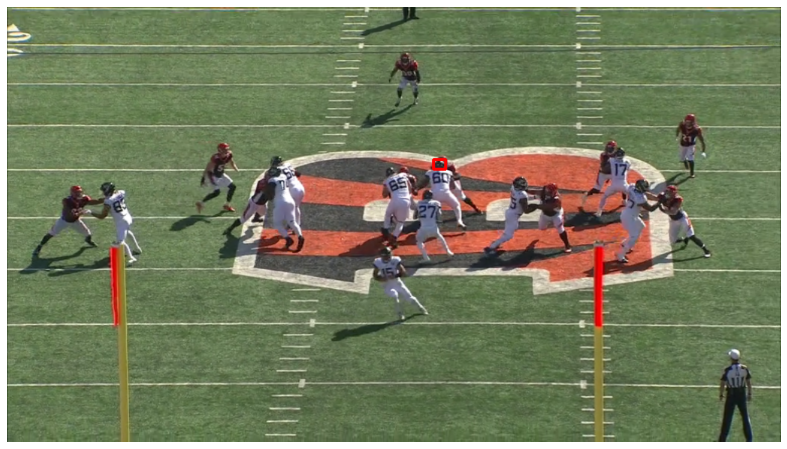

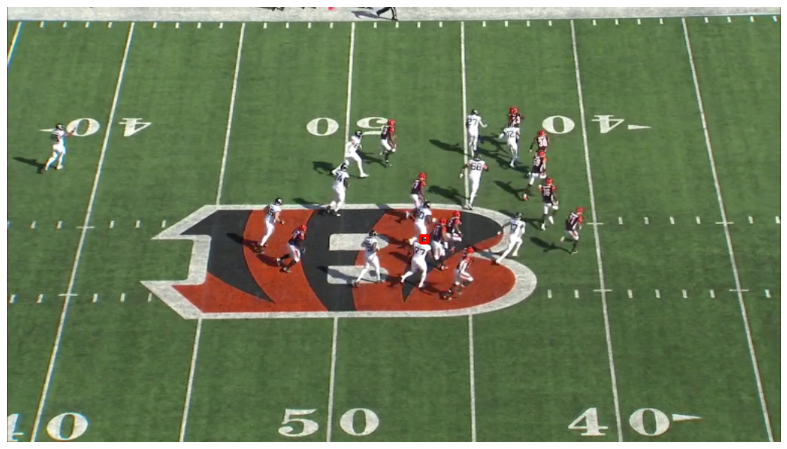

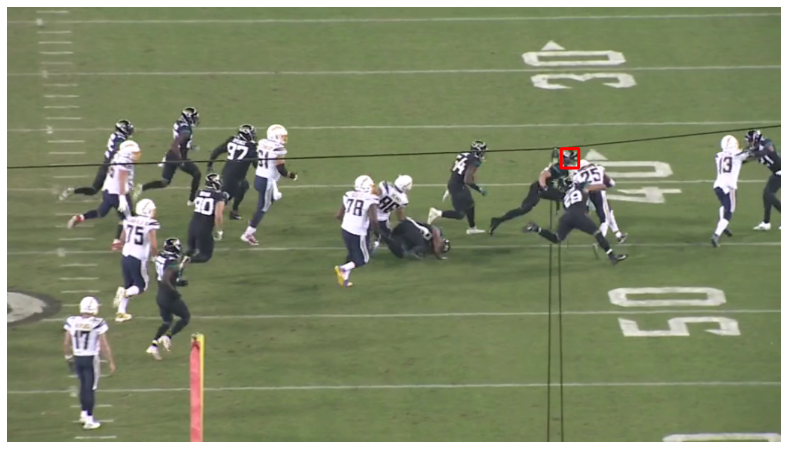

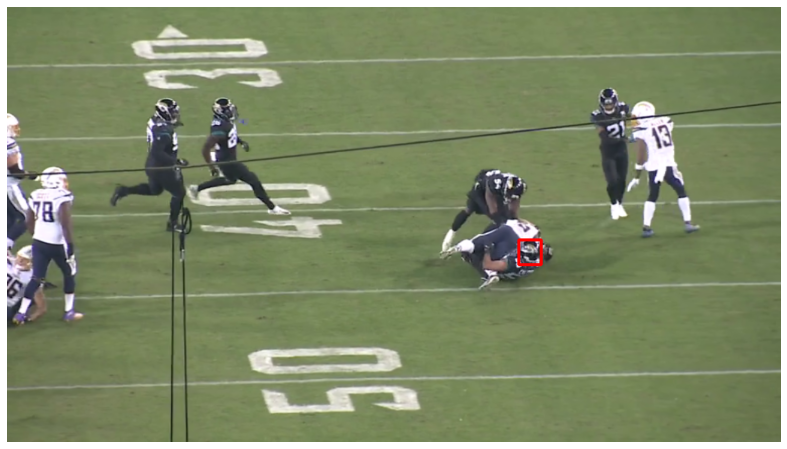

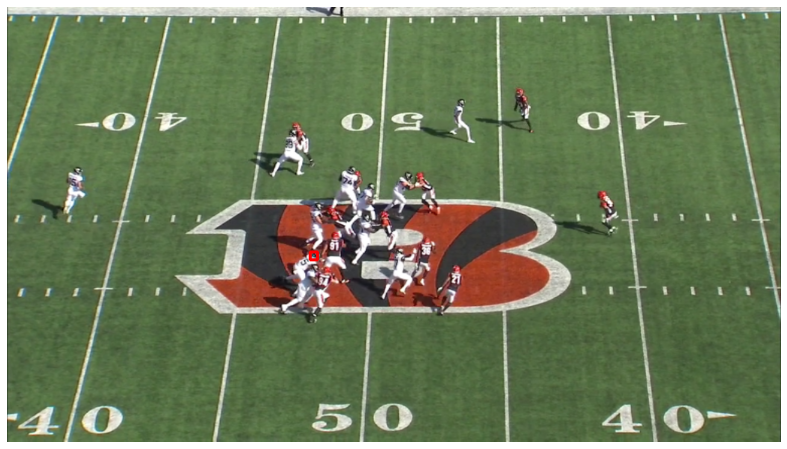

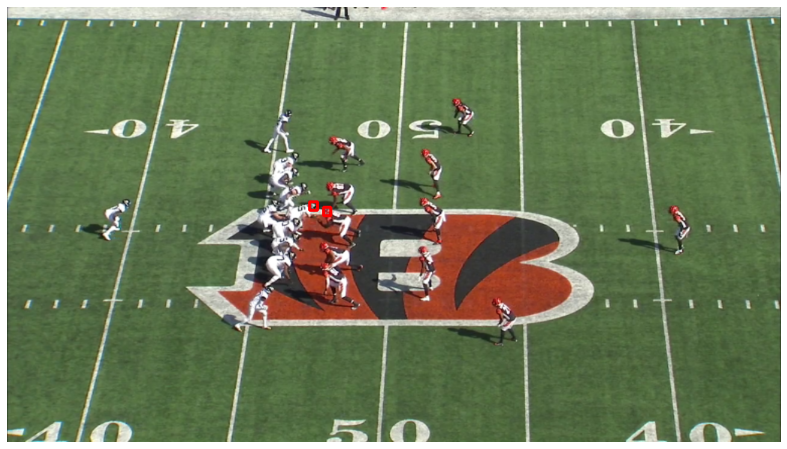

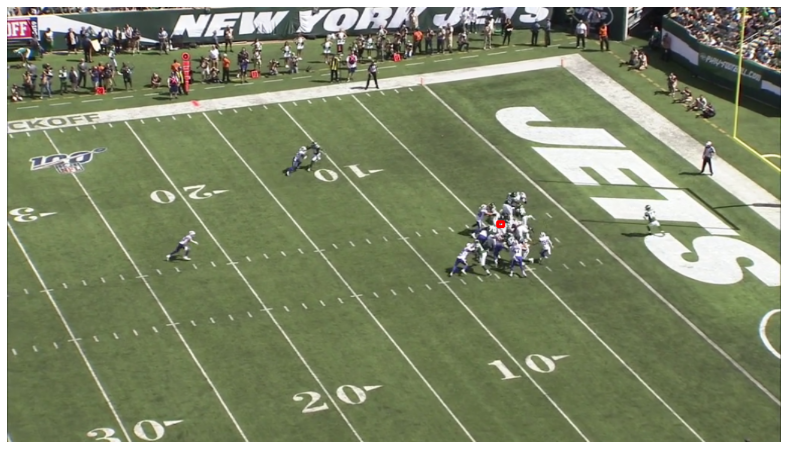

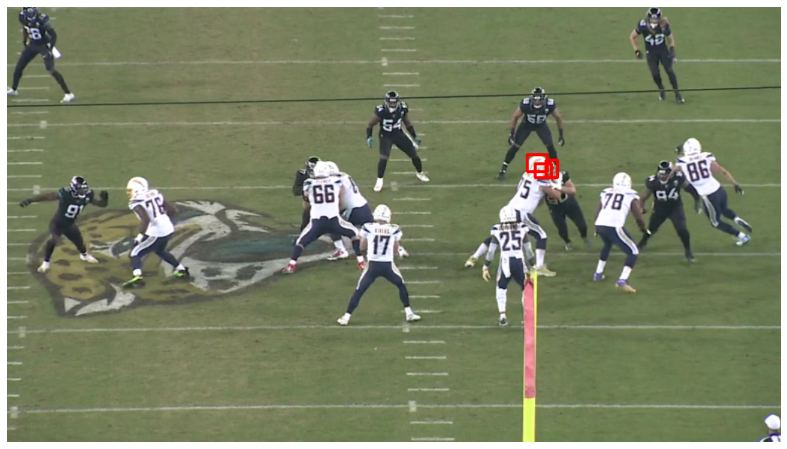

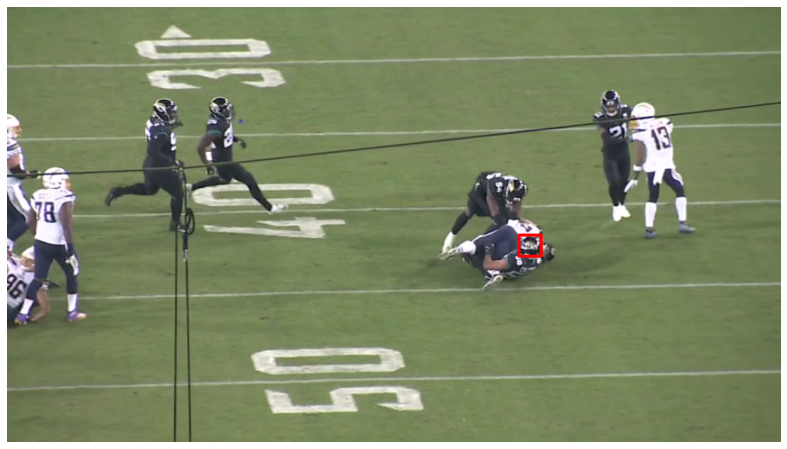

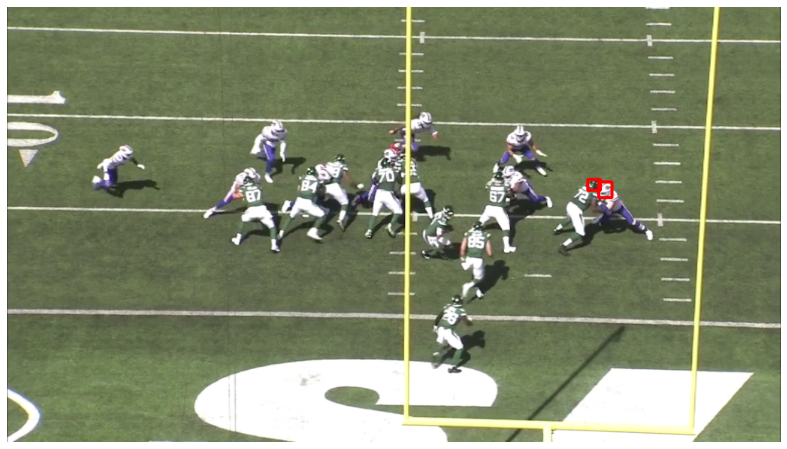

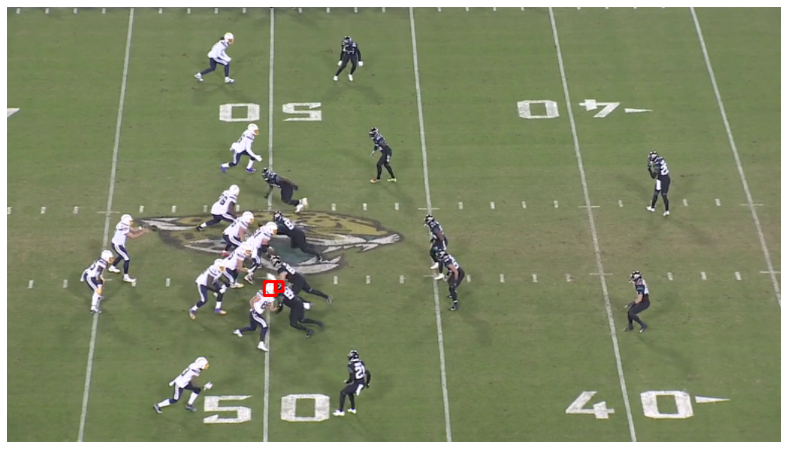

In [20]:
#check prediction

cnt = 0
for images, image_ids in data_loader:
    box_list, score_list = make_predictions(images, score_threshold=DETECTION_THRESHOLD)
    
    for i in range(len(images)):
        sample = images[i].permute(1,2,0).cpu().numpy()
        boxes = box_list[i].astype(np.int32) #.clip(min=0, max=1024 - 1)
        scores = score_list[i]
        
        if len(scores) >= 1:
#             set_trace()
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            sample = cv2.resize(sample , (int(1280), int(720)))
            for box,score in zip(boxes,scores):
                box[0] = box[0] * 1280 / 768
                box[1] = box[1] * 720 / 768
                box[2] = box[2] * 1280 / 768
                box[3] = box[3] * 720 / 768
                cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 3)
            ax.set_axis_off()
            ax.imshow(sample);
            cnt += 1
    if cnt >= 10:
        break

In [ ]:
result_image_ids = []
results_boxes = []
results_scores = []
for images, image_ids in data_loader:
    box_list, score_list = make_predictions(images, score_threshold=DETECTION_THRESHOLD)
    for i, image in enumerate(images):
        boxes = box_list[i]
        scores = score_list[i]
        image_id = image_ids[i]
        boxes[:, 0] = (boxes[:, 0] * 1280 / 1024)
        boxes[:, 1] = (boxes[:, 1] * 720 / 512)
        boxes[:, 2] = (boxes[:, 2] * 1280 / 1024)
        boxes[:, 3] = (boxes[:, 3] * 720 / 512)
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        boxes = boxes.astype(np.int32)
        boxes[:, 0] = boxes[:, 0].clip(min=0, max=1280-1)
        boxes[:, 2] = boxes[:, 2].clip(min=0, max=1280-1)
        boxes[:, 1] = boxes[:, 1].clip(min=0, max=720-1)
        boxes[:, 3] = boxes[:, 3].clip(min=0, max=720-1)
        result_image_ids += [image_id]*len(boxes)
        results_boxes.append(boxes)
        results_scores.append(scores)

In [ ]:
box_df = pd.DataFrame(np.concatenate(results_boxes), columns=['left', 'top', 'width', 'height'])
test_df = pd.DataFrame({'scores':np.concatenate(results_scores), 'image_name':result_image_ids})
test_df = pd.concat([test_df, box_df], axis=1)

test_df = test_df[test_df.scores > DETECTOR_FILTERING_THRESHOLD]
test_df.shape

In [ ]:
#gameKey,playID,view,video,frame,left,width,top,height
#57590,3607,Endzone,57590_003607_Endzone.mp4,1,1,1,1,1
test_df['gameKey'] = test_df.image_name.str.split('_').str[0].astype(int)
test_df['playID'] = test_df.image_name.str.split('_').str[1].astype(int)
test_df['view'] = test_df.image_name.str.split('_').str[2]
test_df['frame'] = test_df.image_name.str.split('_').str[3].str.replace('.png','').astype(int)
test_df['video'] = test_df.image_name.str.rsplit('_',1).str[0] + '.mp4'
test_df = test_df[["gameKey","playID","view","video","frame","left","width","top","height"]]
test_df

Remove all boxes which are not present in both Sidezone and Endzone views

In [ ]:
#################
# FILTER
#################


dropIDX = []
for keys in test_df.groupby(['gameKey', 'playID']).size().to_dict().keys():
    tmp_df = test_df.query('gameKey == @keys[0] and playID == @keys[1]')
    
    for index, row in tmp_df.iterrows():
        if row['view'] == 'Endzone':
            check_df = tmp_df.query('view == "Sideline"')
            if check_df['frame'].apply(lambda x: np.abs(x - row['frame']) <= 4).sum() == 0:
                dropIDX.append(index)
        
        if row['view'] == 'Sideline':
            check_df = tmp_df.query('view == "Endzone"')
            if check_df['frame'].apply(lambda x: np.abs(x - row['frame']) <= 4).sum() == 0:
                dropIDX.append(index)

In [ ]:
test_df = test_df.drop(index = dropIDX).reset_index(drop = True)

In [ ]:
# clearing working dir
# be careful when running this code on local environment!
# !rm -rf *
!mv * /tmp/

In [ ]:
import nflimpact
env = nflimpact.make_env()

if IS_PRIVATE:
    env.predict(test_df) # df is a pandas dataframe of your entire submission file
else:
    sub = pd.read_csv('../input/nfl-impact-detection/sample_submission.csv')
    env.predict(sub)